In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch as tc
import matplotlib.pyplot as plt

from rcgp.rcgp import TemporalRCGP
from rcgp.kernels import Matern32Kernel

plt.rc('font', family='serif', size=16)
plt.rcParams['text.usetex'] = True

In [50]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(55)  # For reproducibility
    x = tc.linspace(0, 1, 100) 
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix, mean = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x)), tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f + 2*np.exp(-5*x)
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)
    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    #outliers_loc = [89, 91, 92, 95, 98, 100, 101, 105, 107, 115]
    outliers_loc = [49, 53, 55, 56, 68, 69, 70, 71]

    noise = np.abs(tc.distributions.Normal(loc=20, scale=5.).sample((len(outliers_loc), )))
    y_outliers[outliers_loc] = noise

    """    outliers_loc2 = [23, 24, 25]
    noise2 = tc.distributions.Normal(loc=0, scale=6.).sample((len(outliers_loc2), ))
    y_outliers[outliers_loc2] = y_outliers[outliers_loc2] + noise2"""
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.1, 2., 0.25)
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

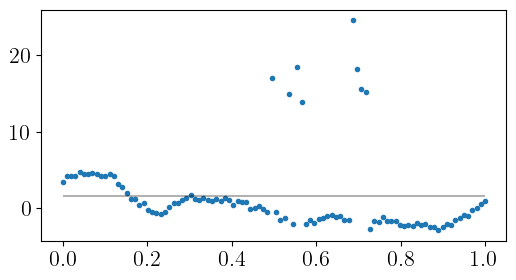

In [51]:
plt.figure(figsize=(6,3))
plt.plot(Xs, Ys_outliers, '.')
plt.hlines(Ys_outliers.mean(), 0, 1, color='black', alpha=0.3)

In [52]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor, weighted_loss : bool):
    S = covs + R
    eps = (Ys - preds).unsqueeze(-1)

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    if weighted_loss:
        Ws = (Ws / Ws.sum()).squeeze()
        return tc.dot(Ws, energies)
    else:
        return tc.sum(energies)

In [65]:
def run_rtgp(alpha, n_steps=70, lr=0.2, weighted_loss=True, plot=False, robust=True):
    losses = []
    strcgp = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys_outliers.reshape(-1,1), p=1, IMQ_exponent=alpha)

    if robust:
        strcgp.adaptive_c()
        strcgp.activate_robustness(func="m_pred")
    else:
        strcgp.deactivate_robustness()

    optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

    for step in range(n_steps):
        _,(preds, covs, R, Ws), _ = strcgp.forward()
        loss = scoring_rule(Ys=Ys.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws, weighted_loss=weighted_loss)
        loss.backward()
        losses.append(loss.clone().detach())
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Reset gradients

    if plot:
        plt.figure(figsize=(8,2))
        plt.plot(losses)
        plt.ylabel("Loss")
        plt.xlabel("Optimisation Step");

    with tc.no_grad(): 
        (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
        pred_strcgp = pred_strcgp.squeeze().numpy()
        #std_strcgp = std_strcgp.squeeze().numpy()
        std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()

    return pred_strcgp, std_strcgp, strcgp_eff

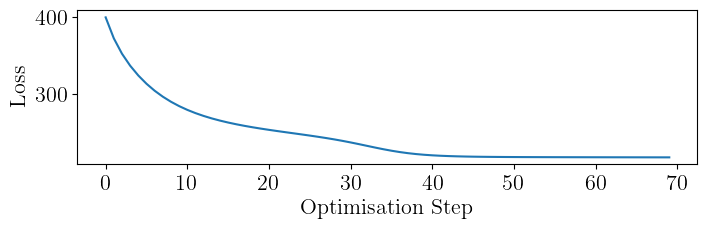

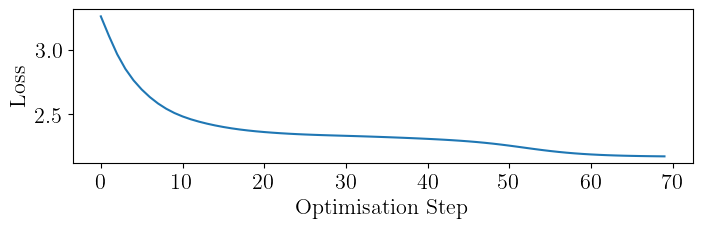

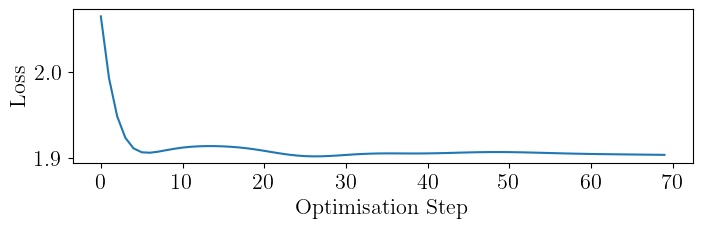

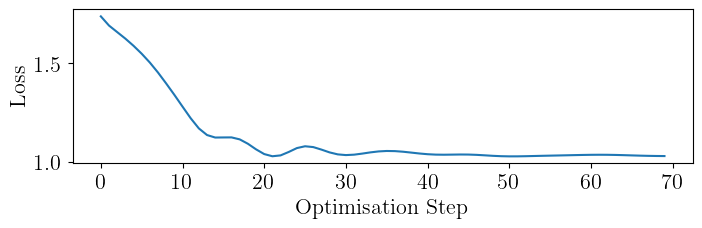

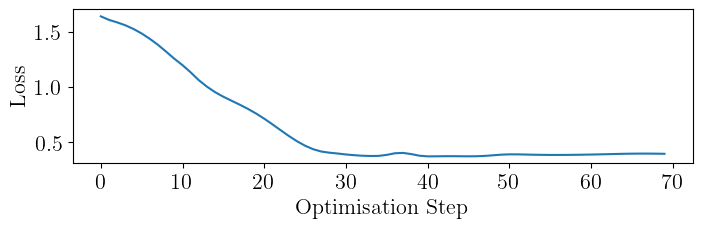

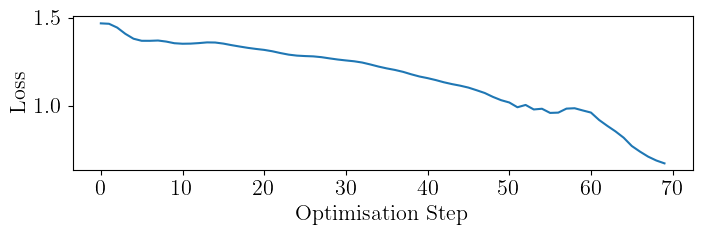

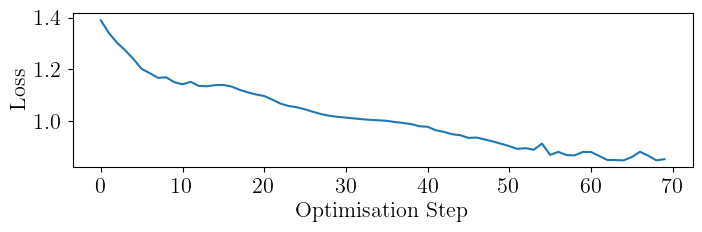

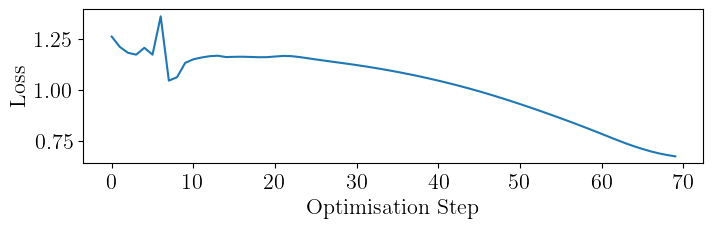

In [66]:
preds_alphas = []
stds_alphas = []
effs_alphas = []
alphas = [0, 1/32, 1/8, 1/4, 1/2, 3/4, 1, 2]

for alpha in alphas:
    if alpha==0:
        pred_strcgp, std_strcgp, strcgp_eff = run_rtgp(alpha=alpha, plot=True, weighted_loss=False, robust=False)
    else:
        pred_strcgp, std_strcgp, strcgp_eff = run_rtgp(alpha=alpha, plot=True)
    preds_alphas.append(pred_strcgp)
    stds_alphas.append(std_strcgp)
    effs_alphas.append(strcgp_eff)

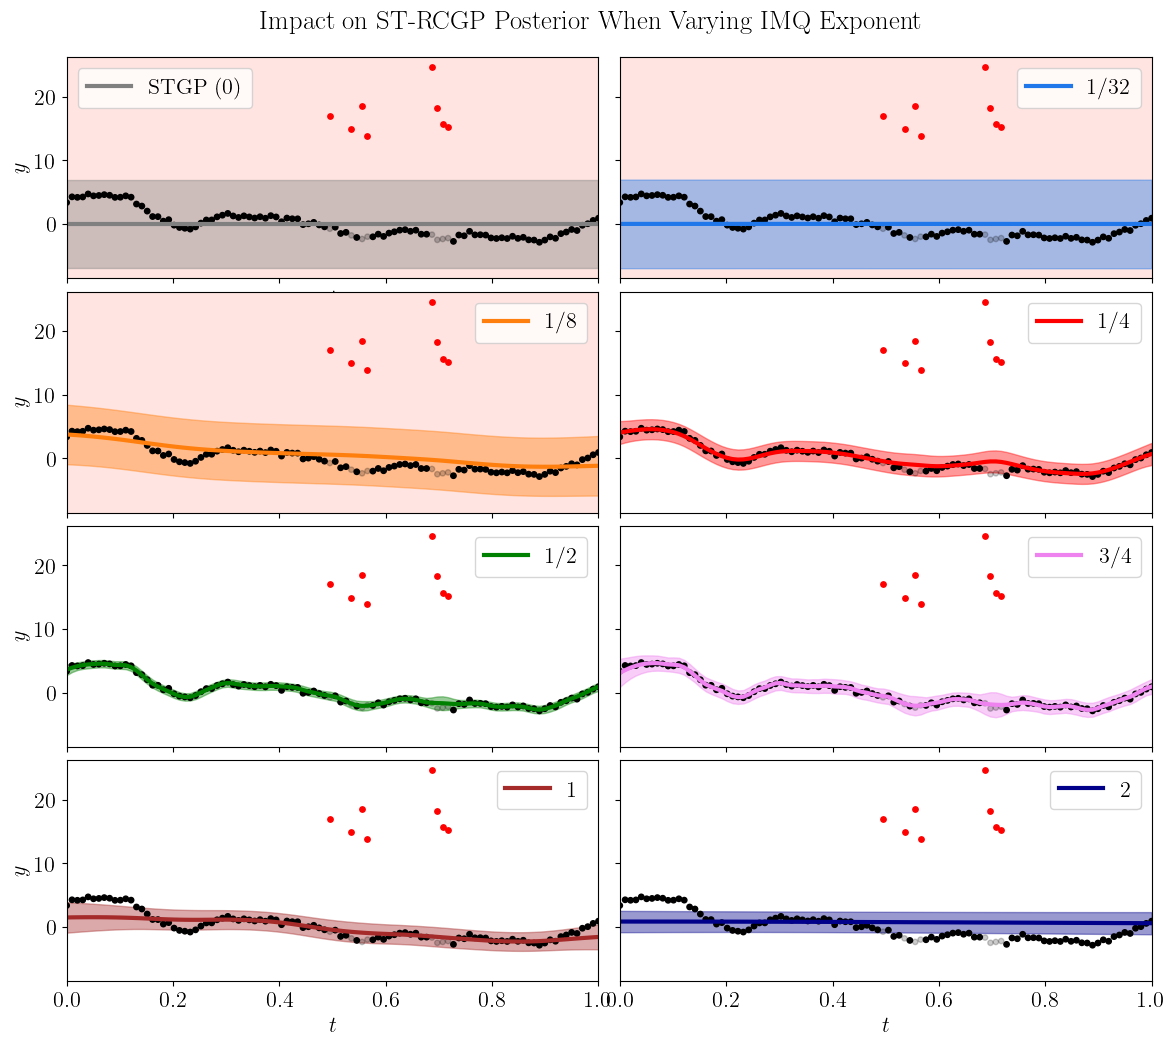

In [ ]:

fig, axs = plt.subplots(4, 2, figsize=(14,12), sharex=True, sharey=True)

lcolors = ["grey", "#1f77e9", "#ff7f0e", "red", "green", "violet", "brown", "darkblue"]

for ax, color, frac, alpha, pred, std in zip(fig.get_axes(), lcolors, ["STGP (0)", "1/32", "1/8", "1/4", "1/2", "3/4", "1", "2"], alphas, preds_alphas, stds_alphas):
    
    ax.plot(Xs, pred, linewidth=3, linestyle='-', color=color, label=frac)
    ax.fill_between(Xs, pred - 3 * std, pred + 3 * std, color=color, alpha=0.4)
    ax.legend()
    if alpha < 1/4:
        ax.set_facecolor('mistyrose')

for ax in fig.get_axes(): 
    colors = ['black' if i not in outliers_loc else (0,0,0,0.2) for i in range(len(Xs))]

    ax.scatter(Xs, Ys, c=colors, s=60, marker='.')
    ax.scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=60, marker='.')


axs[-1, 0].set_xlabel(r"$t$")
axs[-1, 1].set_xlabel(r"$t$")

for i in range(4):
    axs[i, 0].set_ylabel(r"$y$")

fig.subplots_adjust(wspace=0.04, hspace=0.06)

fig.suptitle("Impact on ST-RCGP Posterior When Varying IMQ Exponent", y=0.92)

axs[0, 0].set_xlim(Xs[0], Xs[-1])
axs[0, 0].set_xlabel(r"$t$")

#plt.savefig("./IMQ-exponent-testing.pdf", format='pdf', bbox_inches='tight')
